In [1]:
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from os import getcwd

#Check TensorFlow Version
print('TF version: {}' .format(tf.__version__))

#Check for GPU utilization
if tf.test.gpu_device_name():
    print(' GPU: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU")

TF version: 2.2.0
 GPU: /device:GPU:0


In [2]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        if(logs.get('acc')>=0.99):
            print("\nReached 99% accuracy ")
            self.model.stop_training = True

callbacks = myCallback()

In [3]:
# Define dirs and files
train_dir = '../data/training/'
validation_dir = '../data/validation/'

train_wash_dir = os.path.join(train_dir,'wash')
train_nowash_dir = os.path.join(train_dir,'nowash')
validation_wash_dir = os.path.join(validation_dir,'wash')
validation_nowash_dir = os.path.join(validation_dir,'nowash')

train_wash_fnames = os.listdir(train_wash_dir)
train_nowash_fnames = os.listdir(train_nowash_dir)
validation_wash_fnames = os.listdir(validation_wash_dir)
validation_nowash_fnames = os.listdir(validation_nowash_dir)


print(len(os.listdir(train_wash_dir)))
print(len(os.listdir(train_nowash_dir)))
print(len(os.listdir(validation_wash_dir)))
print(len(os.listdir(validation_nowash_dir)))

total_train=len(os.listdir(train_wash_dir))+ len(os.listdir(train_nowash_dir))
total_val=len(os.listdir(validation_wash_dir))+ len(os.listdir(validation_nowash_dir))

144
167
37
42


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale =1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

#  val data generator
val_datagen = ImageDataGenerator(rescale =1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

#set batch Size
batch_size = 10

#set Image size
imsize = (400,400) 
imshape = (400,400,3)

# Flow training images in batches 
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = batch_size,
                                                    class_mode = 'binary',
                                                    target_size = imsize)

# Flow validation images in batches 
validation_generator =  val_datagen.flow_from_directory( validation_dir,
                                                         batch_size = batch_size,
                                                         class_mode = 'binary',
                                                         target_size = imsize)


Found 311 images belonging to 2 classes.
Found 79 images belonging to 2 classes.


In [5]:
acc_metric = tf.keras.metrics.BinaryAccuracy(name='acc')

In [6]:
#base model, fully trainable but started w/ imagenet weights
base_model = tf.keras.applications.InceptionV3(input_shape = imshape, 
                                                     include_top=False, 
                                                     weights='imagenet')

base_model.trainable = False
base_model.summary()


87916544/87910968 [==============================] - 30s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 400, 400, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 199, 199, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 199, 199, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 199, 199, 32) 0           batch_normalization[0][0]        
_____________________

In [8]:
final_layer = base_model.get_layer('mixed10')
print('shape of last layer is ', final_layer.output_shape)
final_base_output = final_layer.output


#add the last layer
# Flatten the output layer to 1 dimension
x = layers.Flatten()(final_base_output )
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)            

model = Model(base_model.input, x) 

model.summary()

shape of last layer is  (None, 11, 11, 2048)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 400, 400, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 199, 199, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 199, 199, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 199, 199, 32) 0           batch_normalization[0][0]        
_______________________________________________

In [9]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics = acc_metric)

In [10]:
callbacks = myCallback()
history = model.fit(train_generator,
                              steps_per_epoch = total_train // batch_size,
                              validation_data = validation_generator,
                              epochs= 100,
                              validation_steps =  total_val // batch_size,
                              callbacks =[callbacks])

Epoch 1/100
31/31 [==============================] - 78s 3s/step - loss: 6.4878 - acc: 0.7097 - val_loss: 1.1956 - val_acc: 0.8857
Epoch 2/100
31/31 [==============================] - 78s 3s/step - loss: 2.6878 - acc: 0.8040 - val_loss: 0.5840 - val_acc: 0.9000
Epoch 3/100
31/31 [==============================] - 75s 2s/step - loss: 1.7314 - acc: 0.8439 - val_loss: 1.5369 - val_acc: 0.8143
Epoch 4/100
31/31 [==============================] - 76s 2s/step - loss: 1.8709 - acc: 0.8140 - val_loss: 2.6607 - val_acc: 0.7857
Epoch 5/100
31/31 [==============================] - 75s 2s/step - loss: 1.7183 - acc: 0.8173 - val_loss: 0.8541 - val_acc: 0.8286
Epoch 6/100
31/31 [==============================] - 77s 2s/step - loss: 0.9272 - acc: 0.8505 - val_loss: 1.2865 - val_acc: 0.8286
Epoch 7/100
31/31 [==============================] - 77s 2s/step - loss: 0.9137 - acc: 0.8671 - val_loss: 1.2297 - val_acc: 0.8143
Epoch 8/100
31/31 [==============================] - 77s 2s/step - loss: 0.9488 - a

31/31 [==============================] - 76s 2s/step - loss: 0.2869 - acc: 0.9336 - val_loss: 0.8101 - val_acc: 0.8571
Epoch 64/100
31/31 [==============================] - 74s 2s/step - loss: 0.2497 - acc: 0.9369 - val_loss: 1.1634 - val_acc: 0.8286
Epoch 65/100
31/31 [==============================] - 75s 2s/step - loss: 0.5541 - acc: 0.9226 - val_loss: 1.3177 - val_acc: 0.8571
Epoch 66/100
31/31 [==============================] - 75s 2s/step - loss: 0.2822 - acc: 0.9468 - val_loss: 0.8274 - val_acc: 0.8714
Epoch 67/100
31/31 [==============================] - 74s 2s/step - loss: 0.2875 - acc: 0.9568 - val_loss: 0.7079 - val_acc: 0.8857
Epoch 68/100
31/31 [==============================] - 75s 2s/step - loss: 0.4165 - acc: 0.9136 - val_loss: 1.4636 - val_acc: 0.8714
Epoch 69/100
31/31 [==============================] - 76s 2s/step - loss: 0.2190 - acc: 0.9535 - val_loss: 1.2072 - val_acc: 0.8714
Epoch 70/100
31/31 [==============================] - 76s 2s/step - loss: 0.4229 - acc: 0

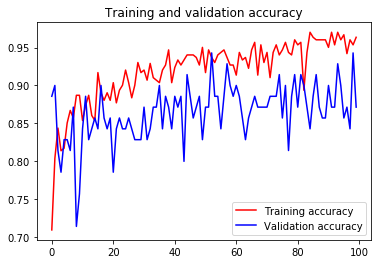

<Figure size 432x288 with 0 Axes>

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [12]:
#now make a Confusion matrix